In [14]:
# =====================================================================
#  TFM UNIR
#  DATASET - GLAUCOMA
#  Autores:
#  Descripción: Clasificación binaria con preprocesamiento avanzado
#  Compatible con Google Colab (GPU)
# =====================================================================
#  Fase 1: CONFIGURACIÓN DE ENTORNO
# =====================================================================

!nvidia-smi || echo "Sin GPU"
import sys, platform
print("Python:", platform.python_version())
!pip -q install timm==1.0.10 opencv-python==4.10.0.84 albumentations==1.3.1 grad-cam==1.5.5

# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Definir rutas
from pathlib import Path

# Define label
# 'RETINOPATIA'
# 'GLAUCOMA'

LABEL = 'GLAUCOMA'

ROOT = Path('/content/drive/MyDrive/UNIR/DATASET/')
DIR_PRESENT = ROOT/LABEL/'PRESENT'
DIR_NOTPRES = ROOT/LABEL/'NOT_PRESENT'

# Validación de rutas
for p in [DIR_PRESENT, DIR_NOTPRES]:
    print(p, "OK?", p.exists())

Tue Jan 27 03:24:24 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P0             29W /   70W |    3042MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

E1 — Chequeo del dataset + conteos + muestra rápida

Present : 394  |  Not present: 309  | Total: 703


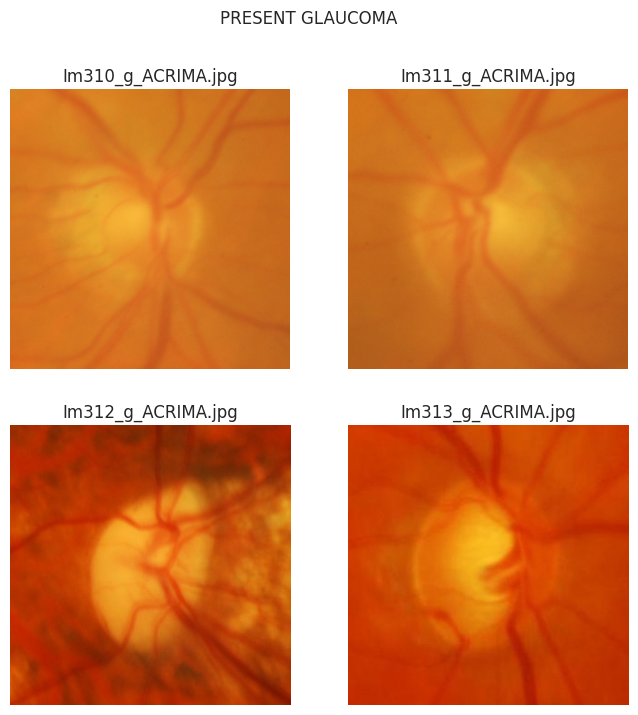

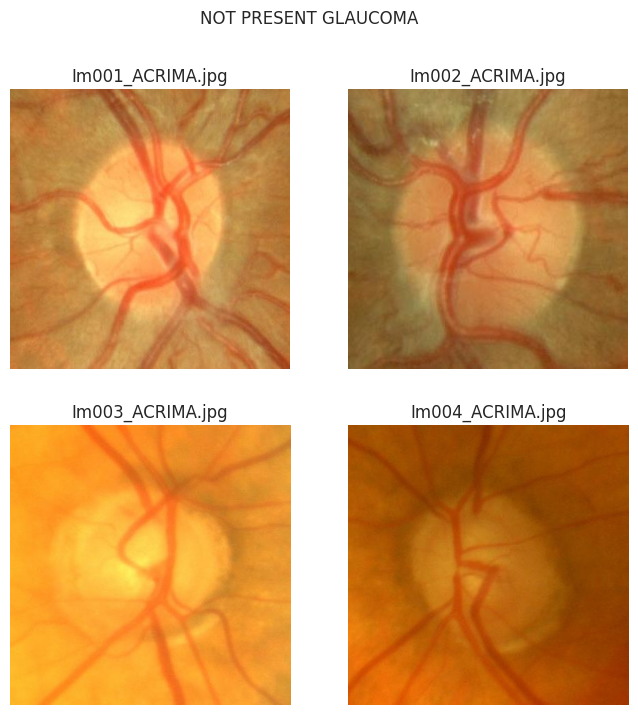

In [15]:
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

def list_images(folder):
    exts = ('*.png','*.jpg','*.jpeg','*.bmp','*.tif','*.tiff')
    files = []
    for e in exts:
        files += glob.glob(os.path.join(folder, e))
    return sorted(files)

pos = list_images(str(DIR_PRESENT))
neg = list_images(str(DIR_NOTPRES))

print(f"Present : {len(pos)}  |  Not present: {len(neg)}  | Total: {len(pos)+len(neg)}")

def show_grid(paths, title):
    n = min(4, len(paths))
    if n == 0:
        print("No hay imágenes en:", title);
        return
    plt.figure(figsize=(8,8))
    for i,p in enumerate(paths[:n], 1):
        try:
            img = Image.open(p).convert('RGB')
            plt.subplot(2,2,i); plt.imshow(img); plt.axis('off'); plt.title(os.path.basename(p)[:32])
        except Exception as e:
            print("Error con", p, e)
    plt.suptitle(title); plt.show()

show_grid(pos, f"PRESENT {LABEL}")
show_grid(neg, f"NOT PRESENT {LABEL}")

E2 — Pipeline de preprocesamiento para imágenes OCT (Optimizado DenseNet-121)

Preprocesamiento específico para OCT optimizado para DenseNet-121 y aplicable a todos los modelos:
- Auto-contraste basado en percentiles (2%-98%) para normalización robusta
- Denoising con filtro mediana (preserva bordes mejor que Gaussiano)
- CLAHE adaptativo (clipLimit=2.0) para realce de contraste local
- Realce de bordes con Unsharp Mask para destacar estructuras retinianas
- Ajuste gamma automático según luminosidad de la imagen
- Redimensionado a 224x224 con interpolación LANCZOS4

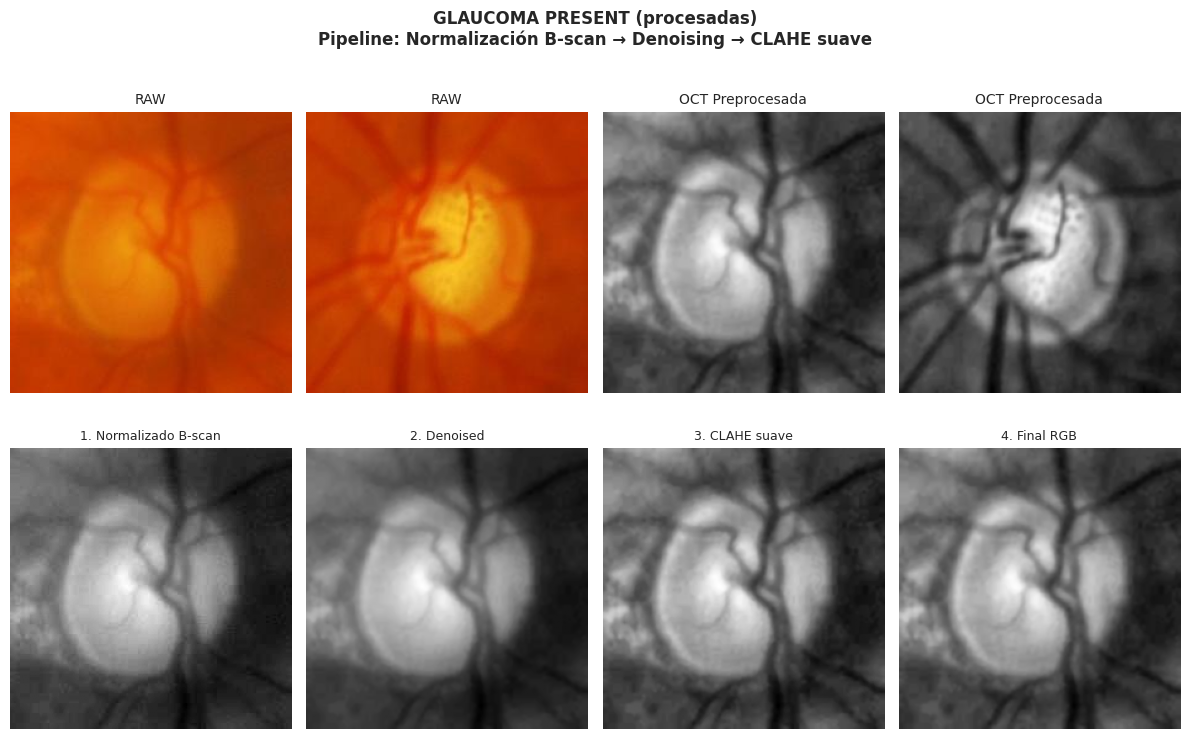

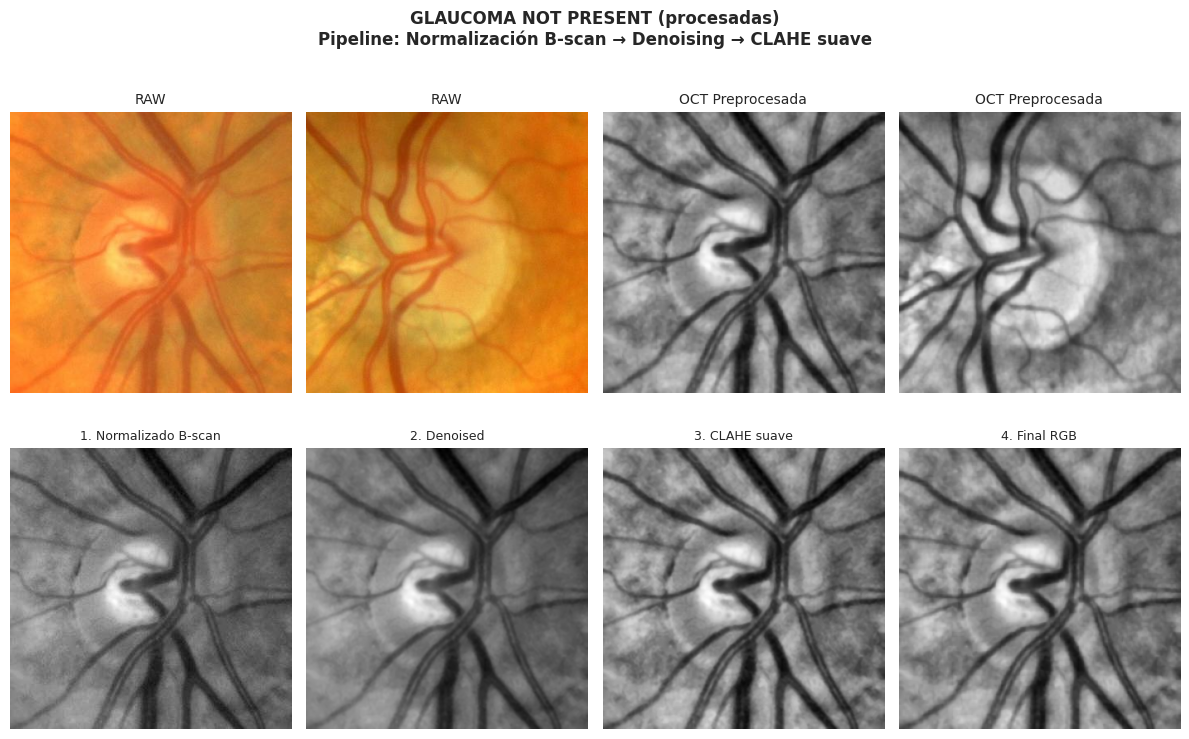

In [ ]:
# Pipeline de preprocesamiento para imágenes OCT

import cv2
import numpy as np
from PIL import Image
import random, matplotlib.pyplot as plt

# =====================================================================
#  CONSTANTES PARA PREPROCESAMIENTO (Optimizado para DenseNet-121)
# =====================================================================
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
DEFAULT_INPUT_SIZE = 224

# =====================================================================
#  FUNCIONES DE PREPROCESAMIENTO PARA OCT (Optimizado para DenseNet-121)
# =====================================================================

def denoise_oct(img_gray):
    """
    Aplica denoising a imagen OCT usando filtro mediana.
    El ruido speckle es común en OCT, este filtro lo reduce preservando bordes.
    """
    # Filtro mediana para reducir ruido speckle (preserva bordes mejor que Gaussiano)
    denoised = cv2.medianBlur(img_gray, 3)
    return denoised

def auto_contrast_oct(img_gray):
    """
    Ajuste automático de contraste basado en percentiles.
    Evita que outliers extremos afecten la normalización.
    Optimizado para imágenes OCT con distribución de intensidad variable.
    """
    # Calcular percentiles para evitar outliers
    p2 = np.percentile(img_gray, 2)
    p98 = np.percentile(img_gray, 98)
    
    # Ajustar rango dinámico
    if p98 > p2:
        img_stretched = np.clip((img_gray - p2) * (255.0 / (p98 - p2)), 0, 255)
    else:
        img_stretched = img_gray
    
    return img_stretched.astype(np.uint8)

def enhance_oct_clahe(img_gray, clip_limit=2.0, tile_size=(8, 8)):
    """
    Aplica ecualización adaptativa del histograma (CLAHE) para OCT.
    ClipLimit=2.0 optimizado para DenseNet-121.
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    enhanced = clahe.apply(img_gray)
    return enhanced

def enhance_edges_oct(img_gray, strength=0.25):
    """
    Realza bordes en imágenes OCT usando Unsharp Mask.
    Ayuda a destacar estructuras retinianas y capas de fibras nerviosas.
    """
    # Crear versión suavizada
    blurred = cv2.GaussianBlur(img_gray, (0, 0), 3)
    
    # Unsharp mask: original + strength * (original - blurred)
    sharpened = cv2.addWeighted(img_gray, 1.0 + strength, blurred, -strength, 0)
    
    return np.clip(sharpened, 0, 255).astype(np.uint8)

def adjust_gamma(img, gamma=1.0):
    """
    Ajuste gamma para mejorar el contraste en diferentes rangos de intensidad.
    Gamma < 1.0: Aclara sombras (útil para OCT oscuros)
    Gamma > 1.0: Oscurece la imagen (útil para OCT sobreexpuestos)
    """
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(img, table)

def preprocess_oct(img_pil, out_size=DEFAULT_INPUT_SIZE, apply_enhancement=True):
    """
    Pipeline completo de preprocesamiento para imágenes OCT.
    OPTIMIZADO PARA DenseNet-121 y compatible con todos los modelos.

    Este pipeline está diseñado para maximizar el rendimiento considerando:
    1. Las características de las imágenes OCT (ruido speckle, bajo contraste)
    2. Los requisitos de entrada de DenseNet-121 (224x224, RGB, normalización ImageNet)
    3. La preservación de características diagnósticas relevantes

    Pasos:
    1. Conversión a escala de grises (OCT es inherentemente monocromático)
    2. Auto-contraste basado en percentiles (2%-98%)
    3. Denoising con filtro mediana (preserva bordes)
    4. Ecualización adaptativa CLAHE (clipLimit=2.0)
    5. Realce de bordes (Unsharp Mask) - opcional
    6. Ajuste gamma automático según luminosidad
    7. Redimensionado a tamaño objetivo con padding
    8. Conversión a RGB (3 canales para compatibilidad con modelos)
    
    Args:
        img_pil: Imagen PIL de entrada
        out_size: Tamaño de salida (default 224 para DenseNet-121)
        apply_enhancement: Si True, aplica realce de bordes
    
    Returns:
        Imagen numpy RGB preprocesada de tamaño (out_size, out_size, 3)
    """
    # Convertir a array numpy
    img_np = np.array(img_pil.convert('RGB'))

    # Paso 1: Convertir a escala de grises (OCT es monocromático)
    if len(img_np.shape) == 3:
        img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_np

    # Paso 2: Auto-contraste basado en percentiles
    img_contrast = auto_contrast_oct(img_gray)

    # Paso 3: Denoising con filtro mediana
    denoised = denoise_oct(img_contrast)

    # Paso 4: Ecualización adaptativa CLAHE
    enhanced = enhance_oct_clahe(denoised, clip_limit=2.0)

    # Paso 5: Realce de bordes (opcional)
    if apply_enhancement:
        enhanced = enhance_edges_oct(enhanced, strength=0.25)

    # Paso 6: Ajuste gamma automático basado en la luminosidad media
    mean_brightness = np.mean(enhanced)
    if mean_brightness < 100:
        gamma = 0.85  # Imagen oscura: aclarar
    elif mean_brightness > 180:
        gamma = 1.15  # Imagen clara: oscurecer ligeramente
    else:
        gamma = 1.0
    enhanced = adjust_gamma(enhanced, gamma)

    # Paso 7: Redimensionar manteniendo aspecto cuadrado
    h, w = enhanced.shape[:2]

    # Padding para hacer cuadrada si es necesario
    side = max(h, w)
    canvas = np.zeros((side, side), dtype=np.uint8)
    y0, x0 = (side - h) // 2, (side - w) // 2
    canvas[y0:y0 + h, x0:x0 + w] = enhanced

    # Redimensionar con interpolación de alta calidad
    resized = cv2.resize(canvas, (out_size, out_size), interpolation=cv2.INTER_LANCZOS4)

    # Paso 8: Convertir a RGB (3 canales idénticos para compatibilidad con modelos)
    img_rgb = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)

    return img_rgb

# =====================================================================
#  VISUALIZACIÓN DEL PIPELINE OCT (Optimizado DenseNet-121)
# =====================================================================

print("=" * 70)
print("PIPELINE DE PREPROCESAMIENTO OPTIMIZADO PARA DenseNet-121")
print("=" * 70)
print(f"\n📐 Tamaño de entrada: {DEFAULT_INPUT_SIZE}x{DEFAULT_INPUT_SIZE} píxeles")
print(f"📊 Normalización ImageNet: mean={IMAGENET_MEAN.tolist()}, std={IMAGENET_STD.tolist()}")
print("\n🔄 Pasos del pipeline:")
print("   1. Conversión a escala de grises")
print("   2. Auto-contraste basado en percentiles (2%-98%)")
print("   3. Denoising con filtro mediana 3x3")
print("   4. CLAHE adaptativo (clipLimit=2.0, tileGrid=8x8)")
print("   5. Realce de bordes (Unsharp Mask, strength=0.25)")
print("   6. Ajuste gamma automático según luminosidad")
print("   7. Padding y redimensionado a 224x224 (INTER_LANCZOS4)")
print("   8. Conversión a RGB (3 canales)")
print("=" * 70)

samples_pos = random.sample(pos, k=min(2, len(pos))) if len(pos) > 0 else []
samples_neg = random.sample(neg, k=min(2, len(neg))) if len(neg) > 0 else []

for title, paths in [("GLAUCOMA PRESENT (procesadas)", samples_pos),
                     ("GLAUCOMA NOT PRESENT (procesadas)", samples_neg)]:
    if not paths:
        print("Sin muestras para", title)
        continue

    plt.figure(figsize=(14, 8))
    for i, pth in enumerate(paths, 1):
        raw = Image.open(pth).convert('RGB')
        pre = preprocess_oct(raw, out_size=224)

        # Imagen original
        plt.subplot(2, 5, i)
        plt.imshow(raw)
        plt.axis('off')
        plt.title("RAW", fontsize=10)

        # Imagen preprocesada
        plt.subplot(2, 5, i + 2)
        plt.imshow(pre)
        plt.axis('off')
        plt.title("Preprocesada DenseNet", fontsize=10)

        # Mostrar pasos intermedios para la primera imagen
        if i == 1:
            img_np = np.array(raw.convert('RGB'))
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
            
            # Paso 2: Auto-contraste
            contrast = auto_contrast_oct(img_gray)
            plt.subplot(2, 5, 5)
            plt.imshow(contrast, cmap='gray')
            plt.axis('off')
            plt.title("1. Auto-contraste", fontsize=9)

            # Paso 3: Denoising
            denoised = denoise_oct(contrast)
            plt.subplot(2, 5, 6)
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')
            plt.title("2. Denoised", fontsize=9)

            # Paso 4: CLAHE
            clahe_img = enhance_oct_clahe(denoised)
            plt.subplot(2, 5, 7)
            plt.imshow(clahe_img, cmap='gray')
            plt.axis('off')
            plt.title("3. CLAHE", fontsize=9)

            # Paso 5: Realce bordes
            edges = enhance_edges_oct(clahe_img)
            plt.subplot(2, 5, 8)
            plt.imshow(edges, cmap='gray')
            plt.axis('off')
            plt.title("4. Realce bordes", fontsize=9)

            plt.subplot(2, 5, 9)
            plt.imshow(pre)
            plt.axis('off')
            plt.title("5. Final RGB", fontsize=9)

    plt.suptitle(f"{title}\nPipeline DenseNet-121: Auto-contraste → Denoising → CLAHE → Realce bordes → Gamma", fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n✅ Pipeline de preprocesamiento optimizado para DenseNet-121 listo")

E3 — Dataset y DataLoader (binario balanceado)

Train: 562 | Val: 141
✔ Dataset 1 (con preprocesamiento OCT) - DataLoaders creados
✔ Dataset 2 (sin preprocesamiento) - DataLoaders creados
Dataset 1 (OCT Preprocesado) - Batch shape: torch.Size([16, 3, 224, 224]) | Labels: [1, 1, 0, 1, 0, 0, 1, 1]
Dataset 2 (Raw) - Batch shape: torch.Size([16, 3, 224, 224]) | Labels: [0, 1, 0, 1, 1, 0, 1, 0]


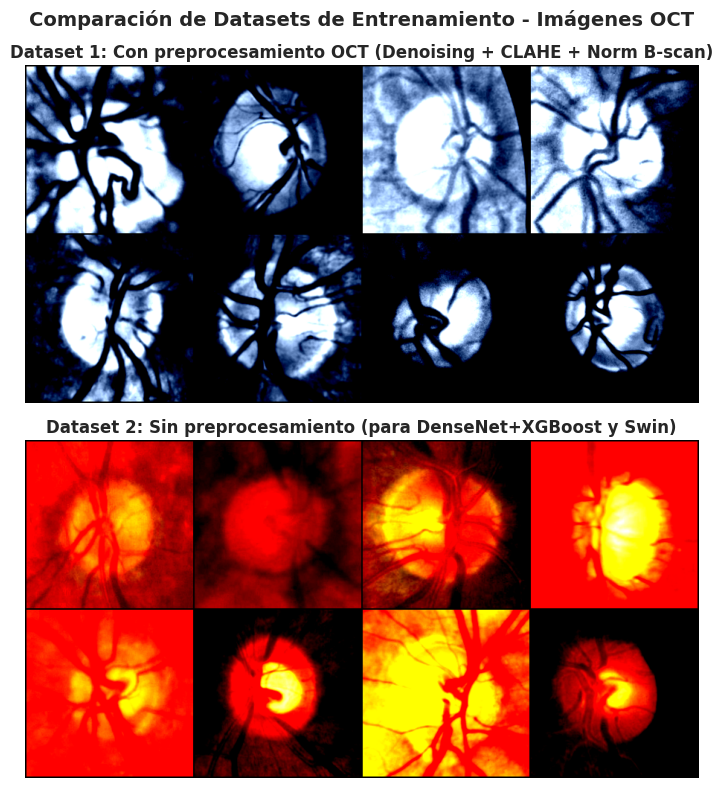

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

# Separación en entrenamiento y validación
all_imgs = [(p, 1) for p in pos] + [(p, 0) for p in neg]
paths, labels = zip(*all_imgs)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Train: {len(train_paths)} | Val: {len(val_paths)}")

# Data Augmentation para Dataset 1 (con preprocesamiento OCT)
train_tfms_ds1 = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.9, 1.0), ratio=(0.9, 1.1), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_tfms_ds1 = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# Data Augmentation para Dataset 2 (sin preprocesamiento OCT, directo)
train_tfms_ds2 = A.Compose([
    A.Resize(height=224, width=224),
    A.RandomResizedCrop(height=224, width=224, scale=(0.9, 1.0), ratio=(0.9, 1.1), p=0.8),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=5, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_tfms_ds2 = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# =====================================================================
#  DATASET 1: Con preprocesamiento OCT (Denoising + CLAHE + Normalización B-scan)
# =====================================================================
class OCTDatasetWithPreprocess(Dataset):
    """Dataset con pipeline OCT: Normalización B-scan + Denoising + CLAHE suave."""
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        img = Image.open(img_path).convert('RGB')
        # Aplicar preprocesamiento OCT
        img = preprocess_oct(img, out_size=224)
        img_np = np.array(img)
        if self.transform:
            img_np = self.transform(image=img_np)['image']
        return img_np, label

# =====================================================================
#  DATASET 2: Sin preprocesamiento (para DenseNet+XGBoost y Swin)
# =====================================================================
class OCTDatasetRaw(Dataset):
    """Dataset sin preprocesamiento OCT (imagen original redimensionada)."""
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        img = Image.open(img_path).convert('RGB')
        # NO aplicar preprocesamiento OCT, solo convertir a array
        img_np = np.array(img)
        if self.transform:
            img_np = self.transform(image=img_np)['image']
        return img_np, label

# =====================================================================
#  CREAR DATALOADERS PARA AMBOS DATASETS
# =====================================================================

BATCH_SIZE = 16

# Dataset 1: Con preprocesamiento OCT (para Modelo 1: DenseNet-121 con OCT preprocessing)
train_dataset_ds1 = OCTDatasetWithPreprocess(train_paths, train_labels, transform=train_tfms_ds1)
val_dataset_ds1 = OCTDatasetWithPreprocess(val_paths, val_labels, transform=val_tfms_ds1)

train_loader_ds1 = DataLoader(train_dataset_ds1, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_ds1 = DataLoader(val_dataset_ds1, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("✔ Dataset 1 (con preprocesamiento OCT) - DataLoaders creados")

# Dataset 2: Sin preprocesamiento (para Modelo 2: DenseNet+XGBoost y Modelo 3: Swin)
train_dataset_ds2 = OCTDatasetRaw(train_paths, train_labels, transform=train_tfms_ds2)
val_dataset_ds2 = OCTDatasetRaw(val_paths, val_labels, transform=val_tfms_ds2)

train_loader_ds2 = DataLoader(train_dataset_ds2, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_ds2 = DataLoader(val_dataset_ds2, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("✔ Dataset 2 (sin preprocesamiento) - DataLoaders creados")

# =====================================================================
#  VISUALIZACIÓN COMPARATIVA DE AMBOS DATASETS
# =====================================================================

import torchvision.utils as vutils

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Muestra Dataset 1
batch_imgs_ds1, batch_lbls_ds1 = next(iter(train_loader_ds1))
print("Dataset 1 (OCT Preprocesado) - Batch shape:", batch_imgs_ds1.shape, "| Labels:", batch_lbls_ds1[:8].tolist())
grid_ds1 = vutils.make_grid(batch_imgs_ds1[:8], nrow=4, normalize=True, value_range=(0,1))
axes[0].imshow(np.transpose(grid_ds1.cpu().numpy(), (1,2,0)))
axes[0].axis('off')
axes[0].set_title("Dataset 1: Con preprocesamiento OCT (Denoising + CLAHE + Norm B-scan)", fontsize=12, fontweight='bold')

# Muestra Dataset 2
batch_imgs_ds2, batch_lbls_ds2 = next(iter(train_loader_ds2))
print("Dataset 2 (Raw) - Batch shape:", batch_imgs_ds2.shape, "| Labels:", batch_lbls_ds2[:8].tolist())
grid_ds2 = vutils.make_grid(batch_imgs_ds2[:8], nrow=4, normalize=True, value_range=(0,1))
axes[1].imshow(np.transpose(grid_ds2.cpu().numpy(), (1,2,0)))
axes[1].axis('off')
axes[1].set_title("Dataset 2: Sin preprocesamiento (para DenseNet+XGBoost y Swin)", fontsize=12, fontweight='bold')

plt.suptitle("Comparación de Datasets de Entrenamiento - Imágenes OCT", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

E4 — Entrenamiento completo

In [ ]:
# =====================================================================
#  CONFIGURACIÓN GENERAL DE ENTRENAMIENTO
# =====================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import timm
import os
import matplotlib.pyplot as plt
import random
import time
import psutil
import gc

# =====================================================================
#  CONFIGURACIÓN DE REPRODUCIBILIDAD (SEMILLAS FIJAS)
# =====================================================================
SEED = 42

def set_seed(seed=SEED):
    """Fija todas las semillas para garantizar reproducibilidad."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # Para multi-GPU
    
    # Configuración determinística de cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Variables de entorno para reproducibilidad
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"✔ Semillas fijadas a {seed} para reproducibilidad")

# Aplicar semillas
set_seed(SEED)

# Función para inicializar workers de DataLoader de forma reproducible
def seed_worker(worker_id):
    """Función para fijar semilla en cada worker del DataLoader."""
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generador para DataLoader reproducible
g = torch.Generator()
g.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

NUM_EPOCHS = 25
PATIENCE = 5
LR = 1e-5
WEIGHT_DECAY = 1e-4

# Configuración específica para Swin Transformer (anti-overfitting MODERADO)
SWIN_CONFIG = {
    'lr': 1e-5,                    # LR más bajo para convergencia estable
    'weight_decay': 0.08,          # Regularización L2 moderada (antes 0.05)
    'drop_rate': 0.4,              # Dropout moderado en clasificador (antes 0.3)
    'drop_path_rate': 0.25,        # Stochastic Depth moderado (antes 0.2)
    'label_smoothing': 0.15,       # Suavizado moderado (antes 0.1)
    'warmup_epochs': 4,            # Más warmup para estabilidad (antes 3)
    'mixup_alpha': 0.3,            # MixUp moderado (antes 0.2)
}

SAVE_DIR = f"/content/drive/MyDrive/UNIR/models_{LABEL}"
os.makedirs(SAVE_DIR, exist_ok=True)

# =====================================================================
#  MÉTRICAS DE EFICIENCIA COMPUTACIONAL
# =====================================================================

def count_parameters(model):
    """Cuenta el número total de parámetros del modelo."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def get_gpu_memory_usage():
    """Obtiene el uso actual de memoria GPU en MB."""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**2  # MB
    return 0

def get_peak_gpu_memory():
    """Obtiene el pico de uso de memoria GPU en MB."""
    if torch.cuda.is_available():
        return torch.cuda.max_memory_allocated() / 1024**2  # MB
    return 0

def reset_gpu_memory_stats():
    """Reinicia las estadísticas de memoria GPU."""
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.empty_cache()
        gc.collect()

def estimate_flops(model, input_size=(1, 3, 224, 224)):
    """
    Estima los FLOPs del modelo usando un forward pass.
    Requiere thop o calcula una aproximación basada en parámetros.
    """
    try:
        from thop import profile, clever_format
        dummy_input = torch.randn(input_size).to(device)
        flops, params = profile(model, inputs=(dummy_input,), verbose=False)
        return flops
    except ImportError:
        # Aproximación basada en parámetros (2 FLOPs por parámetro por forward)
        total_params, _ = count_parameters(model)
        return total_params * 2  # Aproximación simple

def measure_inference_time(model, dataloader, num_batches=10, is_xgboost=False, 
                           feature_extractor=None, scaler=None):
    """
    Mide el tiempo de inferencia promedio por imagen.
    """
    times = []
    total_images = 0
    
    if is_xgboost:
        feature_extractor.eval()
        with torch.no_grad():
            for i, (imgs, _) in enumerate(dataloader):
                if i >= num_batches:
                    break
                batch_size = imgs.size(0)
                imgs = imgs.to(device)
                
                # Medir tiempo de extracción + predicción
                start_time = time.perf_counter()
                features = feature_extractor(imgs)
                features_np = features.cpu().numpy()
                features_scaled = scaler.transform(features_np)
                _ = model.predict_proba(features_scaled)
                
                if device.type == 'cuda':
                    torch.cuda.synchronize()
                    
                end_time = time.perf_counter()
                times.append(end_time - start_time)
                total_images += batch_size
    else:
        model.eval()
        with torch.no_grad():
            for i, (imgs, _) in enumerate(dataloader):
                if i >= num_batches:
                    break
                batch_size = imgs.size(0)
                imgs = imgs.to(device)
                
                start_time = time.perf_counter()
                _ = model(imgs)
                
                if device.type == 'cuda':
                    torch.cuda.synchronize()
                    
                end_time = time.perf_counter()
                times.append(end_time - start_time)
                total_images += batch_size
    
    total_time = sum(times)
    avg_time_per_image = (total_time / total_images) * 1000 if total_images > 0 else 0  # ms
    throughput = total_images / total_time if total_time > 0 else 0  # images/sec
    
    return {
        'avg_time_per_image_ms': avg_time_per_image,
        'throughput_imgs_per_sec': throughput,
        'total_images': total_images
    }

# Diccionario para almacenar métricas de eficiencia
efficiency_metrics = {}

# =====================================================================
#  MIXUP AUGMENTATION (Anti-Overfitting para Transformers)
# =====================================================================
def mixup_data(x, y, alpha=0.2):
    """Aplica MixUp augmentation a un batch."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size, generator=torch.Generator().manual_seed(SEED)).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Calcula la pérdida con MixUp."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =====================================================================
#  FUNCIÓN DE EVALUACIÓN
# =====================================================================
def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(dataloader.dataset)

    metrics = {
        "loss": val_loss,
        "acc": accuracy_score(all_labels, all_preds),
        "prec": precision_score(all_labels, all_preds),
        "rec": recall_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds),
        "auc": roc_auc_score(all_labels, all_probs)
    }
    return metrics

# =====================================================================
#  FUNCIÓN DE ENTRENAMIENTO GENÉRICA (para DenseNet)
# =====================================================================
def train_model(model_name, train_loader, val_loader, save_dir, model_suffix=""):
    """
    Entrena un modelo end-to-end.
    model_suffix: sufijo para diferenciar modelos con diferentes datasets
    """
    # Resetear semilla antes de cada entrenamiento
    set_seed(SEED)
    
    suffix = f"_{model_suffix}" if model_suffix else ""
    full_model_name = f"{model_name}{suffix}"
    
    print(f"\n{'='*60}")
    print(f"  Entrenando modelo: {model_name}{suffix}")
    print(f"{'='*60}")

    # Reiniciar estadísticas de memoria GPU
    reset_gpu_memory_stats()
    training_start_time = time.time()

    model = timm.create_model(model_name, pretrained=True, num_classes=2)
    model = model.to(device)

    # Métricas de eficiencia: parámetros y FLOPs
    total_params, trainable_params = count_parameters(model)
    estimated_flops = estimate_flops(model)
    
    print(f"  Parámetros totales: {total_params:,}")
    print(f"  Parámetros entrenables: {trainable_params:,}")
    print(f"  FLOPs estimados: {estimated_flops:,.0f}")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_auc': [],
        'epoch_times': []  # Tiempo por época
    }

    save_path = os.path.join(save_dir, f"best_{model_name}{suffix}.pth")

    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        model.train()
        train_loss = 0.0

        for imgs, labels in tqdm(train_loader, desc="Entrenando", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)

        train_loss /= len(train_loader.dataset)
        scheduler.step()

        metrics = evaluate_model(model, val_loader, criterion)

        epoch_time = time.time() - epoch_start_time
        history['train_loss'].append(train_loss)
        history['val_loss'].append(metrics['loss'])
        history['val_acc'].append(metrics['acc'])
        history['val_f1'].append(metrics['f1'])
        history['val_auc'].append(metrics['auc'])
        history['epoch_times'].append(epoch_time)

        print(
            f"Train Loss: {train_loss:.4f} | Val Loss: {metrics['loss']:.4f} | "
            f"Acc: {metrics['acc']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['auc']:.4f} | "
            f"Tiempo: {epoch_time:.1f}s"
        )

        # Early stopping
        if metrics['loss'] < best_val_loss:
            best_val_loss = metrics['loss']
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"✔ Modelo guardado en {save_path}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("⏹ Early stopping activado")
                break

    # Calcular métricas de eficiencia finales
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    peak_gpu_memory = get_peak_gpu_memory()
    
    # Medir tiempo de inferencia
    inference_metrics = measure_inference_time(model, val_loader)
    
    # Guardar métricas de eficiencia
    efficiency_metrics[full_model_name] = {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'estimated_flops': estimated_flops,
        'total_training_time_sec': total_training_time,
        'avg_epoch_time_sec': np.mean(history['epoch_times']),
        'peak_gpu_memory_mb': peak_gpu_memory,
        'inference_time_ms': inference_metrics['avg_time_per_image_ms'],
        'throughput_imgs_per_sec': inference_metrics['throughput_imgs_per_sec'],
        'num_epochs_trained': len(history['epoch_times'])
    }
    
    print(f"\n📊 Métricas de Eficiencia - {full_model_name}:")
    print(f"   Tiempo total de entrenamiento: {total_training_time/60:.2f} min")
    print(f"   Tiempo promedio por época: {np.mean(history['epoch_times']):.1f} s")
    print(f"   Pico de memoria GPU: {peak_gpu_memory:.1f} MB")
    print(f"   Tiempo de inferencia: {inference_metrics['avg_time_per_image_ms']:.2f} ms/imagen")
    print(f"   Throughput: {inference_metrics['throughput_imgs_per_sec']:.1f} imgs/s")

    return history, model

# =====================================================================
#  FUNCIÓN DE ENTRENAMIENTO PARA SWIN (Anti-Overfitting)
# =====================================================================
def train_swin_model(train_loader, val_loader, save_dir, config=SWIN_CONFIG):
    """
    Entrena Swin Transformer con técnicas específicas anti-overfitting:
    - Mayor weight decay (regularización L2)
    - Dropout y Stochastic Depth (drop_path)
    - Label Smoothing
    - MixUp augmentation
    - Learning rate warmup
    - Monitoreo de overfitting (gap train/val)
    """
    # Resetear semilla antes del entrenamiento
    set_seed(SEED)
    
    model_name = "swin_tiny_patch4_window7_224"
    suffix = "_raw_regularized"
    full_model_name = f"{model_name}{suffix}"
    
    print(f"\n{'='*60}")
    print(f"  Entrenando modelo: {model_name} (con regularización)")
    print(f"{'='*60}")
    print(f"  Configuración anti-overfitting:")
    print(f"    - Weight Decay: {config['weight_decay']}")
    print(f"    - Dropout Rate: {config['drop_rate']}")
    print(f"    - Drop Path Rate: {config['drop_path_rate']}")
    print(f"    - Label Smoothing: {config['label_smoothing']}")
    print(f"    - MixUp Alpha: {config['mixup_alpha']}")
    print(f"{'='*60}")

    # Reiniciar estadísticas de memoria GPU
    reset_gpu_memory_stats()
    training_start_time = time.time()

    # Crear modelo con dropout y stochastic depth
    model = timm.create_model(
        model_name, 
        pretrained=True, 
        num_classes=2,
        drop_rate=config['drop_rate'],           # Dropout en clasificador
        drop_path_rate=config['drop_path_rate']  # Stochastic Depth
    )
    model = model.to(device)

    # Métricas de eficiencia: parámetros y FLOPs
    total_params, trainable_params = count_parameters(model)
    estimated_flops = estimate_flops(model)
    
    print(f"  Parámetros totales: {total_params:,}")
    print(f"  Parámetros entrenables: {trainable_params:,}")
    print(f"  FLOPs estimados: {estimated_flops:,.0f}")

    # Label Smoothing para reducir overfitting
    criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
    
    # Optimizer con mayor weight decay
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config['lr'], 
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.999)
    )
    
    # Scheduler con warmup
    total_steps = NUM_EPOCHS * len(train_loader)
    warmup_steps = config['warmup_epochs'] * len(train_loader)
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        return 0.5 * (1 + np.cos(np.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
    
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_val_auc = 0.0  # Usar AUC en lugar de loss para early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_f1': [],
        'val_auc': [],
        'overfitting_gap': [],  # Monitorear gap train-val
        'epoch_times': []  # Tiempo por época
    }

    save_path = os.path.join(save_dir, f"best_{model_name}{suffix}.pth")

    for epoch in range(NUM_EPOCHS):
        epoch_start_time = time.time()
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for imgs, labels in tqdm(train_loader, desc="Entrenando", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            # Aplicar MixUp con probabilidad 0.5
            use_mixup = np.random.random() < 0.5 and config['mixup_alpha'] > 0
            
            if use_mixup:
                imgs, labels_a, labels_b, lam = mixup_data(imgs, labels, config['mixup_alpha'])
            
            optimizer.zero_grad()
            outputs = model(imgs)
            
            if use_mixup:
                loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            else:
                loss = criterion(outputs, labels)
            
            loss.backward()
            
            # Gradient clipping para estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item() * imgs.size(0)
            
            # Calcular accuracy de entrenamiento (sin mixup)
            if not use_mixup:
                _, predicted = outputs.max(1)
                train_total += labels.size(0)
                train_correct += predicted.eq(labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / train_total if train_total > 0 else 0

        # Evaluación en validación
        metrics = evaluate_model(model, val_loader, nn.CrossEntropyLoss())  # Sin label smoothing

        # Calcular gap de overfitting
        overfitting_gap = train_acc - metrics['acc']
        
        epoch_time = time.time() - epoch_start_time
        history['train_loss'].append(train_loss)
        history['val_loss'].append(metrics['loss'])
        history['val_acc'].append(metrics['acc'])
        history['val_f1'].append(metrics['f1'])
        history['val_auc'].append(metrics['auc'])
        history['overfitting_gap'].append(overfitting_gap)
        history['epoch_times'].append(epoch_time)

        current_lr = optimizer.param_groups[0]['lr']
        
        print(
            f"Train Loss: {train_loss:.4f} (Acc: {train_acc:.4f}) | "
            f"Val Loss: {metrics['loss']:.4f} | "
            f"Val Acc: {metrics['acc']:.4f} | F1: {metrics['f1']:.4f} | AUC: {metrics['auc']:.4f} | "
            f"Tiempo: {epoch_time:.1f}s"
        )
        print(f"LR: {current_lr:.2e} | Overfitting Gap: {overfitting_gap:+.4f}")
        
        # Alerta de overfitting
        if overfitting_gap > 0.15:
            print(f"⚠️ Posible overfitting detectado (gap > 15%)")

        # Early stopping basado en AUC (más robusto que loss)
        if metrics['auc'] > best_val_auc:
            best_val_auc = metrics['auc']
            best_val_loss = metrics['loss']
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"✔ Modelo guardado (AUC: {best_val_auc:.4f})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print("⏹ Early stopping activado")
                break

    # Cargar mejor modelo
    model.load_state_dict(torch.load(save_path))
    
    # Calcular métricas de eficiencia finales
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    peak_gpu_memory = get_peak_gpu_memory()
    
    # Medir tiempo de inferencia
    inference_metrics = measure_inference_time(model, val_loader)
    
    # Guardar métricas de eficiencia
    efficiency_metrics[full_model_name] = {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'estimated_flops': estimated_flops,
        'total_training_time_sec': total_training_time,
        'avg_epoch_time_sec': np.mean(history['epoch_times']),
        'peak_gpu_memory_mb': peak_gpu_memory,
        'inference_time_ms': inference_metrics['avg_time_per_image_ms'],
        'throughput_imgs_per_sec': inference_metrics['throughput_imgs_per_sec'],
        'num_epochs_trained': len(history['epoch_times'])
    }
    
    print(f"\n📊 Métricas de Eficiencia - {full_model_name}:")
    print(f"   Tiempo total de entrenamiento: {total_training_time/60:.2f} min")
    print(f"   Tiempo promedio por época: {np.mean(history['epoch_times']):.1f} s")
    print(f"   Pico de memoria GPU: {peak_gpu_memory:.1f} MB")
    print(f"   Tiempo de inferencia: {inference_metrics['avg_time_per_image_ms']:.2f} ms/imagen")
    print(f"   Throughput: {inference_metrics['throughput_imgs_per_sec']:.1f} imgs/s")
    
    return history, model


# =====================================================================
#  MODELO HÍBRIDO: DenseNet-121 + XGBoost (sin preprocesamiento ROI)
# =====================================================================

!pip -q install xgboost

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import joblib

class DenseNetFeatureExtractor(nn.Module):
    """DenseNet-121 como extractor de características (sin capa de clasificación)."""
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model('densenet121', pretrained=pretrained, num_classes=0)

    def forward(self, x):
        return self.backbone(x)

def extract_features(model, dataloader):
    """Extrae características usando el backbone de DenseNet-121."""
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Extrayendo features"):
            imgs = imgs.to(device)
            features = model(imgs)
            all_features.append(features.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.vstack(all_features), np.array(all_labels)

def train_densenet_xgboost(train_loader, val_loader, save_dir):
    """
    Entrena el modelo híbrido DenseNet-121 + XGBoost.
    Usa Dataset 2 (sin preprocesamiento OCT).
    """
    # Resetear semilla
    set_seed(SEED)
    
    full_model_name = "densenet121_xgboost"
    
    print(f"\n{'='*60}")
    print("  Entrenando modelo: DenseNet-121 + XGBoost (Dataset 2)")
    print(f"{'='*60}")

    # Reiniciar estadísticas de memoria GPU
    reset_gpu_memory_stats()
    training_start_time = time.time()

    # Paso 1: Crear extractor de características
    print("\n[1/4] Cargando DenseNet-121 como extractor de características...")
    feature_extractor = DenseNetFeatureExtractor(pretrained=True).to(device)
    feature_extractor.eval()

    # Métricas de eficiencia: parámetros del extractor
    total_params, trainable_params = count_parameters(feature_extractor)
    estimated_flops = estimate_flops(feature_extractor)
    
    print(f"  Parámetros del extractor: {total_params:,}")
    print(f"  FLOPs estimados: {estimated_flops:,.0f}")

    # Paso 2: Extraer características
    print("\n[2/4] Extrayendo características del conjunto de entrenamiento...")
    feature_extraction_start = time.time()
    X_train, y_train = extract_features(feature_extractor, train_loader)
    print(f"    Features de entrenamiento: {X_train.shape}")

    print("\n[3/4] Extrayendo características del conjunto de validación...")
    X_val, y_val = extract_features(feature_extractor, val_loader)
    print(f"    Features de validación: {X_val.shape}")
    feature_extraction_time = time.time() - feature_extraction_start

    # Paso 3: Normalizar características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Paso 4: Entrenar XGBoost
    print("\n[4/4] Entrenando clasificador XGBoost...")
    xgb_train_start = time.time()

    xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': ['logloss','auc'],
        'max_depth': 5,
        'learning_rate': 0.05,
        'n_estimators': 300,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.1,
        'reg_lambda': 1.0,
        'random_state': SEED,  # Semilla fija para XGBoost
        'use_label_encoder': False,
        'tree_method': 'hist',
        'early_stopping_rounds': 20
    }

    xgb_model = xgb.XGBClassifier(**xgb_params)

    xgb_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_val_scaled, y_val)],
        verbose=True
    )
    xgb_train_time = time.time() - xgb_train_start

    # Evaluar
    y_pred = xgb_model.predict(X_val_scaled)
    y_probs = xgb_model.predict_proba(X_val_scaled)[:, 1]

    metrics = {
        "acc": accuracy_score(y_val, y_pred),
        "prec": precision_score(y_val, y_pred),
        "rec": recall_score(y_val, y_pred),
        "f1": f1_score(y_val, y_pred),
        "auc": roc_auc_score(y_val, y_probs)
    }

    print(f"\n📊 Resultados DenseNet-121 + XGBoost:")
    print(f"   Accuracy:  {metrics['acc']:.4f}")
    print(f"   Precision: {metrics['prec']:.4f}")
    print(f"   Recall:    {metrics['rec']:.4f}")
    print(f"   F1-Score:  {metrics['f1']:.4f}")
    print(f"   AUC-ROC:   {metrics['auc']:.4f}")

    # Guardar modelos
    joblib.dump(scaler, os.path.join(save_dir, "densenet_xgb_scaler.pkl"))
    joblib.dump(xgb_model, os.path.join(save_dir, "densenet_xgb_model.pkl"))
    torch.save(feature_extractor.state_dict(), os.path.join(save_dir, "densenet_feature_extractor.pth"))
    print(f"\n✔ Modelos guardados en {save_dir}")

    # Crear history
    evals_result = xgb_model.evals_result()
    n_rounds = len(evals_result['validation_0']['logloss'])

    history = {
        'train_loss': [0.0] * n_rounds,
        'val_loss': evals_result['validation_0']['logloss'],
        'val_acc': [metrics['acc']] * n_rounds,
        'val_f1': [metrics['f1']] * n_rounds,
        'val_auc': evals_result['validation_0']['auc']
    }

    # Calcular métricas de eficiencia finales
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    peak_gpu_memory = get_peak_gpu_memory()
    
    # Medir tiempo de inferencia
    inference_metrics = measure_inference_time(
        xgb_model, val_loader, 
        is_xgboost=True, 
        feature_extractor=feature_extractor, 
        scaler=scaler
    )
    
    # Contar parámetros de XGBoost (número de árboles * nodos promedio)
    xgb_params_count = sum(
        len(booster.get_dump()) for booster in [xgb_model.get_booster()]
    ) * xgb_model.n_estimators
    
    # Guardar métricas de eficiencia
    efficiency_metrics[full_model_name] = {
        'total_params': total_params + xgb_params_count,  # DenseNet + XGBoost
        'trainable_params': trainable_params,
        'estimated_flops': estimated_flops,
        'total_training_time_sec': total_training_time,
        'feature_extraction_time_sec': feature_extraction_time,
        'xgb_training_time_sec': xgb_train_time,
        'avg_epoch_time_sec': xgb_train_time / n_rounds,
        'peak_gpu_memory_mb': peak_gpu_memory,
        'inference_time_ms': inference_metrics['avg_time_per_image_ms'],
        'throughput_imgs_per_sec': inference_metrics['throughput_imgs_per_sec'],
        'num_epochs_trained': n_rounds
    }
    
    print(f"\n📊 Métricas de Eficiencia - {full_model_name}:")
    print(f"   Tiempo total de entrenamiento: {total_training_time/60:.2f} min")
    print(f"   Tiempo extracción de features: {feature_extraction_time:.1f} s")
    print(f"   Tiempo entrenamiento XGBoost: {xgb_train_time:.1f} s")
    print(f"   Pico de memoria GPU: {peak_gpu_memory:.1f} MB")
    print(f"   Tiempo de inferencia: {inference_metrics['avg_time_per_image_ms']:.2f} ms/imagen")
    print(f"   Throughput: {inference_metrics['throughput_imgs_per_sec']:.1f} imgs/s")

    return history, feature_extractor, xgb_model, scaler


# =====================================================================
#  RECREAR DATALOADERS CON REPRODUCIBILIDAD
# =====================================================================
print("\n" + "="*70)
print("  Recreando DataLoaders con configuración de reproducibilidad")
print("="*70)

# Recrear DataLoaders con worker_init_fn y generator para reproducibilidad
train_loader_ds1 = DataLoader(
    train_dataset_ds1, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)
val_loader_ds1 = DataLoader(
    val_dataset_ds1, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

train_loader_ds2 = DataLoader(
    train_dataset_ds2, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=2, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)
val_loader_ds2 = DataLoader(
    val_dataset_ds2, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

print("✔ DataLoaders recreados con semillas fijas")

# =====================================================================
#  EJECUCIÓN DE LOS 3 MODELOS HÍBRIDOS
# =====================================================================

all_histories = {}
trained_models = {}

print("\n" + "="*70)
print("           ENTRENAMIENTO DE MODELOS HÍBRIDOS")
print("="*70)
print(f"""
📋 Esquema de entrenamiento (Imágenes OCT - Glaucoma):
   🔒 SEMILLA FIJA: {SEED} (Reproducibilidad garantizada)

   MODELO 1: DenseNet-121 con preprocesamiento OCT
             └── Dataset 1 (Denoising + CLAHE suave + Norm B-scan)

   MODELO 2: DenseNet-121 + XGBoost
             └── Dataset 2 (sin preprocesamiento)

   MODELO 3: Swin Transformer (con regularización anti-overfitting)
             └── Dataset 2 (sin preprocesamiento)
             └── Técnicas: Dropout, DropPath, Label Smoothing, MixUp
""")

# =====================================================================
#  MODELO 1: DenseNet-121 con preprocesamiento OCT (Dataset 1)
# =====================================================================
print("\n" + "="*70)
print("  MODELO 1: DenseNet-121 + OCT Preprocessing (Dataset 1)")
print("="*70)

history_densenet_oct, model_densenet_oct = train_model(
    model_name="densenet121",
    train_loader=train_loader_ds1,  # Dataset 1 con preprocesamiento OCT
    val_loader=val_loader_ds1,
    save_dir=SAVE_DIR,
    model_suffix="oct_preprocess"
)
all_histories["densenet121_oct_preprocess"] = history_densenet_oct
trained_models["densenet121_oct_preprocess"] = {
    'model': model_densenet_oct,
    'dataset': 'Dataset 1 (OCT Preprocess)',
    'val_loader': val_loader_ds1
}

# =====================================================================
#  MODELO 2: DenseNet-121 + XGBoost sin preprocesamiento (Dataset 2)
# =====================================================================
print("\n" + "="*70)
print("  MODELO 2: DenseNet-121 + XGBoost (Dataset 2)")
print("="*70)

history_hybrid, feat_extractor, xgb_clf, feat_scaler = train_densenet_xgboost(
    train_loader=train_loader_ds2,  # Dataset 2 sin preprocesamiento
    val_loader=val_loader_ds2,
    save_dir=SAVE_DIR
)
all_histories["densenet121_xgboost"] = history_hybrid
trained_models["densenet121_xgboost"] = {
    'model': xgb_clf,
    'feature_extractor': feat_extractor,
    'scaler': feat_scaler,
    'dataset': 'Dataset 2 (Raw)',
    'val_loader': val_loader_ds2
}

# =====================================================================
#  MODELO 3: Swin Transformer CON REGULARIZACIÓN (Dataset 2)
# =====================================================================
print("\n" + "="*70)
print("  MODELO 3: Swin Transformer con Regularización (Dataset 2)")
print("="*70)

# Usar la función especializada con técnicas anti-overfitting
history_swin, model_swin = train_swin_model(
    train_loader=train_loader_ds2,  # Dataset 2 sin preprocesamiento
    val_loader=val_loader_ds2,
    save_dir=SAVE_DIR,
    config=SWIN_CONFIG
)
all_histories["swin_tiny_raw"] = history_swin
trained_models["swin_tiny_raw"] = {
    'model': model_swin,
    'dataset': 'Dataset 2 (Raw)',
    'val_loader': val_loader_ds2
}

# =====================================================================
#  COMPARACIÓN FINAL DE MODELOS
# =====================================================================

print("\n" + "="*70)
print("           COMPARACIÓN FINAL DE MODELOS")
print("="*70)

print(f"\n🔒 Reproducibilidad: SEED = {SEED}")
print("\n📊 Resumen de configuración (Imágenes OCT - Glaucoma):")
print("-" * 70)
print(f"{'Modelo':<35} {'Dataset':<25} {'Regularización':<15}")
print("-" * 70)
print(f"{'DenseNet-121 + OCT Preprocess':<35} {'Dataset 1':<25} {'Estándar':<15}")
print(f"{'DenseNet-121 + XGBoost':<35} {'Dataset 2':<25} {'Estándar':<15}")
print(f"{'Swin Transformer':<35} {'Dataset 2':<25} {'Anti-Overfit':<15}")
print("-" * 70)

print("\n📈 Métricas finales:")
print("-" * 70)
for model_name, hist in all_histories.items():
    print(
        f"{model_name:<35} → "
        f"Acc: {hist['val_acc'][-1]:.4f}, "
        f"F1: {hist['val_f1'][-1]:.4f}, "
        f"AUC: {hist['val_auc'][-1]:.4f}"
    )

# Mostrar gap de overfitting para Swin si está disponible
if 'overfitting_gap' in all_histories.get('swin_tiny_raw', {}):
    final_gap = all_histories['swin_tiny_raw']['overfitting_gap'][-1]
    print(f"\n📉 Swin Overfitting Gap (train_acc - val_acc): {final_gap:+.4f}")

Usando dispositivo: cuda

           ENTRENAMIENTO DE MODELOS HÍBRIDOS

📋 Esquema de entrenamiento (Imágenes OCT - Glaucoma):

   MODELO 1: DenseNet-121 con preprocesamiento OCT
             └── Dataset 1 (Denoising + CLAHE suave + Norm B-scan)

   MODELO 2: DenseNet-121 + XGBoost
             └── Dataset 2 (sin preprocesamiento)

   MODELO 3: Swin Transformer
             └── Dataset 2 (sin preprocesamiento)


  MODELO 1: DenseNet-121 + OCT Preprocessing (Dataset 1)

  Entrenando modelo: densenet121_oct_preprocess

Epoch 1/25


Train Loss: 0.7133 | Val Loss: 0.7534 | Acc: 0.4255 | F1: 0.1980 | AUC: 0.5404
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 2/25


Train Loss: 0.6714 | Val Loss: 0.7001 | Acc: 0.5248 | F1: 0.5732 | AUC: 0.5255
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 3/25


Train Loss: 0.6255 | Val Loss: 0.6306 | Acc: 0.6312 | F1: 0.7204 | AUC: 0.7227
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 4/25


Train Loss: 0.6223 | Val Loss: 0.6164 | Acc: 0.6099 | F1: 0.7059 | AUC: 0.7423
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 5/25


Train Loss: 0.5958 | Val Loss: 0.5916 | Acc: 0.6809 | F1: 0.7458 | AUC: 0.7822
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 6/25


Train Loss: 0.5665 | Val Loss: 0.5746 | Acc: 0.6879 | F1: 0.7609 | AUC: 0.8130
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 7/25


Train Loss: 0.5733 | Val Loss: 0.5551 | Acc: 0.7447 | F1: 0.7978 | AUC: 0.8405
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 8/25


Train Loss: 0.5621 | Val Loss: 0.5536 | Acc: 0.7376 | F1: 0.7978 | AUC: 0.8628
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 9/25


Train Loss: 0.5490 | Val Loss: 0.5448 | Acc: 0.6950 | F1: 0.7676 | AUC: 0.8695
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 10/25


Train Loss: 0.5494 | Val Loss: 0.5488 | Acc: 0.7447 | F1: 0.7931 | AUC: 0.8655

Epoch 11/25


Train Loss: 0.5418 | Val Loss: 0.5535 | Acc: 0.7589 | F1: 0.8068 | AUC: 0.8610

Epoch 12/25


Train Loss: 0.5508 | Val Loss: 0.5462 | Acc: 0.7092 | F1: 0.7760 | AUC: 0.8550

Epoch 13/25


Train Loss: 0.5447 | Val Loss: 0.5480 | Acc: 0.7376 | F1: 0.7933 | AUC: 0.8430

Epoch 14/25


Train Loss: 0.5429 | Val Loss: 0.5414 | Acc: 0.7234 | F1: 0.7869 | AUC: 0.8673
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 15/25


Train Loss: 0.5411 | Val Loss: 0.5417 | Acc: 0.7305 | F1: 0.7935 | AUC: 0.8597

Epoch 16/25


Train Loss: 0.5284 | Val Loss: 0.5320 | Acc: 0.7021 | F1: 0.7766 | AUC: 0.8550
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 17/25


Train Loss: 0.5091 | Val Loss: 0.5080 | Acc: 0.7376 | F1: 0.7933 | AUC: 0.8824
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 18/25


Train Loss: 0.4900 | Val Loss: 0.4829 | Acc: 0.7376 | F1: 0.7978 | AUC: 0.9045
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 19/25


Train Loss: 0.4742 | Val Loss: 0.4514 | Acc: 0.8511 | F1: 0.8743 | AUC: 0.9304
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 20/25


Train Loss: 0.4482 | Val Loss: 0.4187 | Acc: 0.8652 | F1: 0.8820 | AUC: 0.9490
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 21/25


Train Loss: 0.4361 | Val Loss: 0.4133 | Acc: 0.8440 | F1: 0.8675 | AUC: 0.9424
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 22/25


Train Loss: 0.4215 | Val Loss: 0.4027 | Acc: 0.8652 | F1: 0.8876 | AUC: 0.9402
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 23/25


Train Loss: 0.3945 | Val Loss: 0.3849 | Acc: 0.8652 | F1: 0.8862 | AUC: 0.9549
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 24/25


Train Loss: 0.3832 | Val Loss: 0.3684 | Acc: 0.8440 | F1: 0.8721 | AUC: 0.9618
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

Epoch 25/25


Train Loss: 0.3813 | Val Loss: 0.3444 | Acc: 0.8936 | F1: 0.9091 | AUC: 0.9651
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_densenet121_oct_preprocess.pth

  MODELO 2: DenseNet-121 + XGBoost (Dataset 2)

  Entrenando modelo: DenseNet-121 + XGBoost (Dataset 2)

[1/4] Cargando DenseNet-121 como extractor de características...

[2/4] Extrayendo características del conjunto de entrenamiento...


Extrayendo features: 100%|██████████| 36/36 [00:05<00:00,  6.88it/s]


    Features de entrenamiento: (562, 1024)

[3/4] Extrayendo características del conjunto de validación...


Extrayendo features: 100%|██████████| 9/9 [00:01<00:00,  8.28it/s]
/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [03:29:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


    Features de validación: (141, 1024)

[4/4] Entrenando clasificador XGBoost...
[0]	validation_0-logloss:0.65933	validation_0-auc:0.88322
[1]	validation_0-logloss:0.63753	validation_0-auc:0.91149
[2]	validation_0-logloss:0.61624	validation_0-auc:0.91578
[3]	validation_0-logloss:0.59190	validation_0-auc:0.94702
[4]	validation_0-logloss:0.57512	validation_0-auc:0.94120
[5]	validation_0-logloss:0.55744	validation_0-auc:0.94875
[6]	validation_0-logloss:0.53937	validation_0-auc:0.95406
[7]	validation_0-logloss:0.52281	validation_0-auc:0.95835
[8]	validation_0-logloss:0.50990	validation_0-auc:0.96019
[9]	validation_0-logloss:0.49604	validation_0-auc:0.96488
[10]	validation_0-logloss:0.48092	validation_0-auc:0.96876
[11]	validation_0-logloss:0.46896	validation_0-auc:0.97040
[12]	validation_0-logloss:0.45835	validation_0-auc:0.97285
[13]	validation_0-logloss:0.44775	validation_0-auc:0.97407
[14]	validation_0-logloss:0.43720	validation_0-auc:0.97162
[15]	validation_0-logloss:0.42978	validatio

Train Loss: 0.4806 | Val Loss: 0.2057 | Acc: 0.9433 | F1: 0.9500 | AUC: 0.9896
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_swin_tiny_patch4_window7_224_raw.pth

Epoch 2/25


Train Loss: 0.1865 | Val Loss: 0.0859 | Acc: 0.9574 | F1: 0.9615 | AUC: 0.9980
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_swin_tiny_patch4_window7_224_raw.pth

Epoch 3/25


Train Loss: 0.0782 | Val Loss: 0.0568 | Acc: 0.9716 | F1: 0.9740 | AUC: 0.9992
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_swin_tiny_patch4_window7_224_raw.pth

Epoch 4/25


Train Loss: 0.0691 | Val Loss: 0.0515 | Acc: 0.9787 | F1: 0.9814 | AUC: 1.0000
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_swin_tiny_patch4_window7_224_raw.pth

Epoch 5/25


Train Loss: 0.0650 | Val Loss: 0.0360 | Acc: 0.9858 | F1: 0.9872 | AUC: 1.0000
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_swin_tiny_patch4_window7_224_raw.pth

Epoch 6/25


Train Loss: 0.0420 | Val Loss: 0.0117 | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000
✔ Modelo guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/best_swin_tiny_patch4_window7_224_raw.pth

Epoch 7/25


Train Loss: 0.0233 | Val Loss: 0.0191 | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000

Epoch 8/25


Train Loss: 0.0218 | Val Loss: 0.0164 | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000

Epoch 9/25


Train Loss: 0.0197 | Val Loss: 0.0138 | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000

Epoch 10/25


Train Loss: 0.0145 | Val Loss: 0.0132 | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000

Epoch 11/25


Train Loss: 0.0197 | Val Loss: 0.0132 | Acc: 1.0000 | F1: 1.0000 | AUC: 1.0000
⏹ Early stopping activado

           COMPARACIÓN FINAL DE MODELOS

📊 Resumen de configuración (Imágenes OCT - Glaucoma):
----------------------------------------------------------------------
Modelo                              Dataset                   Preprocesamiento
----------------------------------------------------------------------
DenseNet-121 + OCT Preprocess       Dataset 1                 Sí (OCT)       
DenseNet-121 + XGBoost              Dataset 2                 No             
Swin Transformer                    Dataset 2                 No             
----------------------------------------------------------------------

📈 Métricas finales:
----------------------------------------------------------------------
densenet121_oct_preprocess          → Acc: 0.8936, F1: 0.9091, AUC: 0.9651
densenet121_xgboost                 → Acc: 0.9362, F1: 0.9448, AUC: 0.9853
swin_tiny_raw                  

## E5 — Visualización de Resultados

Gráficos comparativos para el informe académico:
- Curvas ROC comparativas
- Matrices de confusión
- Grad-CAM para interpretabilidad

✔ Curvas ROC guardadas en /content/drive/MyDrive/UNIR/models_GLAUCOMA/roc_curves_comparison.png


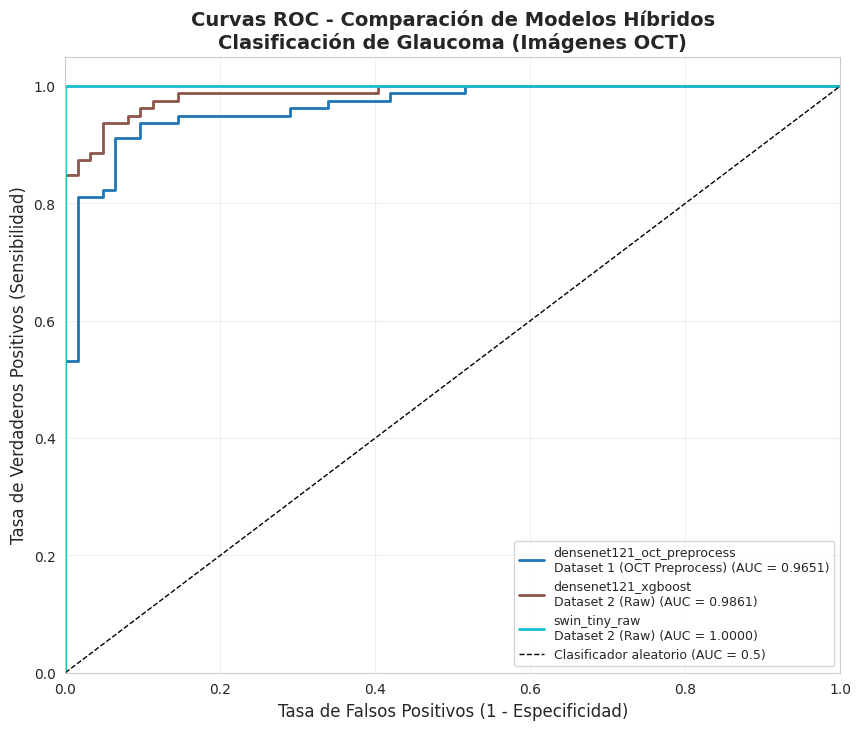

In [19]:
# =====================================================================
#  CURVAS ROC COMPARATIVAS
# =====================================================================

import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import pandas as pd

sns.set_style("whitegrid")

def get_predictions(model, dataloader, is_xgboost=False, feature_extractor=None, scaler=None):
    """Obtiene predicciones y probabilidades de un modelo."""
    if is_xgboost:
        # Para el modelo híbrido DenseNet + XGBoost
        feature_extractor.eval()
        all_features = []
        all_labels = []

        with torch.no_grad():
            for imgs, labels in dataloader:
                imgs = imgs.to(device)
                features = feature_extractor(imgs)
                all_features.append(features.cpu().numpy())
                all_labels.extend(labels.numpy())

        X = np.vstack(all_features)
        X_scaled = scaler.transform(X)
        y_probs = model.predict_proba(X_scaled)[:, 1]
        return np.array(all_labels), y_probs
    else:
        # Para modelos end-to-end (DenseNet, Swin, etc.)
        model.eval()
        all_labels, all_probs = [], []

        with torch.no_grad():
            for imgs, labels in dataloader:
                imgs = imgs.to(device)
                outputs = model(imgs)
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
                all_probs.extend(probs)
                all_labels.extend(labels.numpy())

        return np.array(all_labels), np.array(all_probs)

def plot_roc_curves_comparison(models_dict, save_path=None):
    """Genera curvas ROC comparativas para todos los modelos."""
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))

    for (model_name, model_info), color in zip(models_dict.items(), colors):
        # Usar el val_loader apropiado para cada modelo
        val_loader = model_info['val_loader']

        if "xgboost" in model_name:
            y_true, y_probs = get_predictions(
                model_info['model'], val_loader,
                is_xgboost=True,
                feature_extractor=model_info['feature_extractor'],
                scaler=model_info['scaler']
            )
        else:
            y_true, y_probs = get_predictions(model_info['model'], val_loader)

        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc_score = roc_auc_score(y_true, y_probs)

        # Añadir info del dataset al label
        dataset_info = model_info.get('dataset', '')
        label = f'{model_name}\n{dataset_info} (AUC = {auc_score:.4f})'
        plt.plot(fpr, tpr, color=color, lw=2, label=label)

    plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Clasificador aleatorio (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)', fontsize=12)
    plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)', fontsize=12)
    plt.title('Curvas ROC - Comparación de Modelos Híbridos\nClasificación de Glaucoma (Imágenes OCT)',
              fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✔ Curvas ROC guardadas en {save_path}")
    plt.show()

# =====================================================================
#  GENERAR CURVAS ROC
# =====================================================================

if trained_models:
    plot_roc_curves_comparison(trained_models,
                               save_path=os.path.join(SAVE_DIR, "roc_curves_comparison.png"))

✔ Matrices de confusión guardadas en /content/drive/MyDrive/UNIR/models_GLAUCOMA/confusion_matrices.png


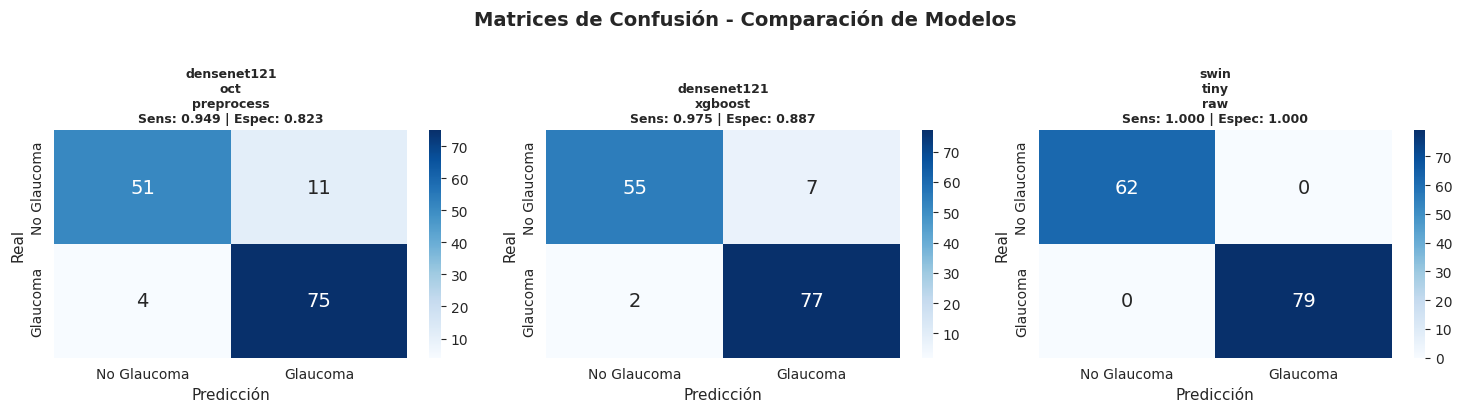

In [20]:
# =====================================================================
#  MATRICES DE CONFUSIÓN
# =====================================================================

def plot_confusion_matrices(models_dict, save_path=None):
    """Genera matrices de confusión para todos los modelos."""
    n_models = len(models_dict)
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))

    if n_models == 1:
        axes = [axes]

    class_names = ['No Glaucoma', 'Glaucoma']

    for ax, (model_name, model_info) in zip(axes, models_dict.items()):
        val_loader = model_info['val_loader']

        if "xgboost" in model_name:
            y_true, y_probs = get_predictions(
                model_info['model'], val_loader,
                is_xgboost=True,
                feature_extractor=model_info['feature_extractor'],
                scaler=model_info['scaler']
            )
        else:
            y_true, y_probs = get_predictions(model_info['model'], val_loader)

        y_pred = (y_probs >= 0.5).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        # Calcular métricas
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        # Plotear
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={'size': 14})
        ax.set_xlabel('Predicción', fontsize=11)
        ax.set_ylabel('Real', fontsize=11)

        # Título con nombre corto
        short_name = model_name.replace('_', '\n')
        ax.set_title(f'{short_name}\nSens: {sensitivity:.3f} | Espec: {specificity:.3f}',
                     fontsize=9, fontweight='bold')

    plt.suptitle('Matrices de Confusión - Comparación de Modelos',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✔ Matrices de confusión guardadas en {save_path}")
    plt.show()

# Generar matrices de confusión
if trained_models:
    plot_confusion_matrices(trained_models,
                           save_path=os.path.join(SAVE_DIR, "confusion_matrices.png"))

In [21]:
# =====================================================================
#  TABLA COMPARATIVA DE MÉTRICAS
# =====================================================================

def generate_metrics_table(models_dict, save_path=None):
    """Genera tabla comparativa de métricas para todos los modelos."""
    results = []

    for model_name, model_info in models_dict.items():
        val_loader = model_info['val_loader']

        if "xgboost" in model_name:
            y_true, y_probs = get_predictions(
                model_info['model'], val_loader,
                is_xgboost=True,
                feature_extractor=model_info['feature_extractor'],
                scaler=model_info['scaler']
            )
        else:
            y_true, y_probs = get_predictions(model_info['model'], val_loader)

        y_pred = (y_probs >= 0.5).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        results.append({
            'Modelo': model_name,
            'Dataset': model_info.get('dataset', 'N/A'),
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precisión': precision_score(y_true, y_pred, zero_division=0),
            'Sensibilidad': recall_score(y_true, y_pred, zero_division=0),
            'Especificidad': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'F1-Score': f1_score(y_true, y_pred, zero_division=0),
            'AUC-ROC': roc_auc_score(y_true, y_probs)
        })

    df = pd.DataFrame(results)

    # Mostrar tabla
    print("\n📊 TABLA COMPARATIVA DE MÉTRICAS - MODELOS HÍBRIDOS")
    print("="*100)
    display(df.set_index('Modelo').round(4))

    # Guardar CSV
    if save_path:
        csv_path = save_path.replace('.png', '.csv')
        df.to_csv(csv_path, index=False)
        print(f"\n✔ Tabla guardada en {csv_path}")

    return df

# Generar tabla
if trained_models:
    metrics_df = generate_metrics_table(trained_models,
                                        save_path=os.path.join(SAVE_DIR, "metrics_comparison.csv"))


📊 TABLA COMPARATIVA DE MÉTRICAS - MODELOS HÍBRIDOS


Dataset  Accuracy  Precisión  \
Modelo                                                                        
densenet121_oct_preprocess  Dataset 1 (OCT Preprocess)    0.8936     0.8721   
densenet121_xgboost                    Dataset 2 (Raw)    0.9362     0.9167   
swin_tiny_raw                          Dataset 2 (Raw)    1.0000     1.0000   

                            Sensibilidad  Especificidad  F1-Score  AUC-ROC  
Modelo                                                                      
densenet121_oct_preprocess        0.9494         0.8226    0.9091   0.9651  
densenet121_xgboost               0.9747         0.8871    0.9448   0.9861  
swin_tiny_raw                     1.0000         1.0000    1.0000   1.0000


✔ Tabla guardada en /content/drive/MyDrive/UNIR/models_GLAUCOMA/metrics_comparison.csv


### Grad-CAM: Interpretabilidad del Modelo

Visualización de las regiones que el modelo considera más relevantes para la clasificación.

📍 Muestras seleccionadas para Grad-CAM: 4 imágenes
   - Con Glaucoma: 2
   - Sin Glaucoma: 2
✔ Grad-CAM guardado en /content/drive/MyDrive/UNIR/models_GLAUCOMA/gradcam_comparison.png


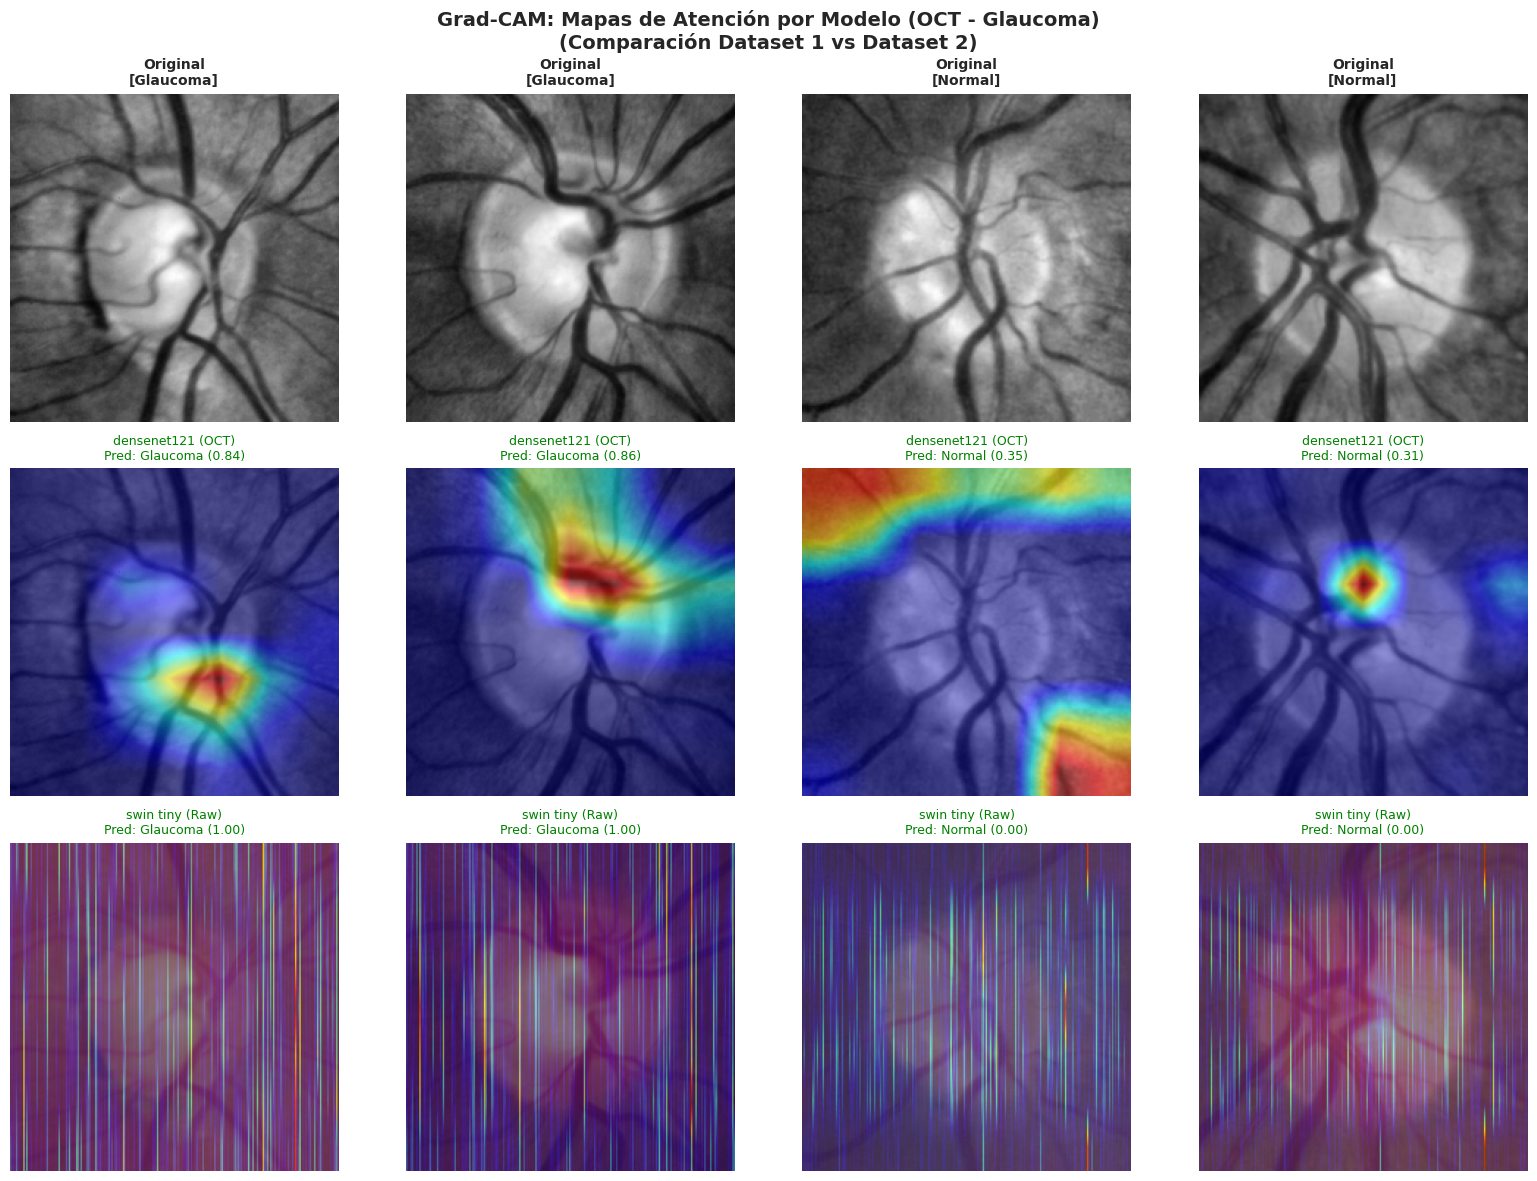

In [22]:
# =====================================================================
#  GRAD-CAM PARA INTERPRETABILIDAD
# =====================================================================

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def get_target_layer(model, model_name):
    """Obtiene la capa objetivo para Grad-CAM según la arquitectura."""
    if 'densenet' in model_name:
        return [model.features.denseblock4.denselayer16.conv2]
    elif 'swin' in model_name:
        return [model.layers[-1].blocks[-1].norm1]
    elif 'resnet' in model_name:
        return [model.layer4[-1]]
    elif 'efficientnet' in model_name:
        return [model.conv_head]
    elif 'vit' in model_name:
        return [model.blocks[-1].norm1]
    else:
        return [list(model.children())[-2]]

def visualize_gradcam_grid(models_dict, sample_paths, sample_labels, save_path=None):
    """Genera visualizaciones Grad-CAM comparativas para modelos end-to-end."""

    # Filtrar solo modelos end-to-end (no XGBoost)
    cnn_models = {k: v for k, v in models_dict.items() if "xgboost" not in k}

    if not cnn_models:
        print("⚠ No hay modelos CNN disponibles para Grad-CAM")
        return

    n_samples = min(4, len(sample_paths))
    n_models = len(cnn_models)

    fig, axes = plt.subplots(n_models + 1, n_samples, figsize=(4*n_samples, 4*(n_models+1)))

    if n_samples == 1:
        axes = axes.reshape(-1, 1)

    # Fila 0: imágenes originales
    for j in range(n_samples):
        img_pil = Image.open(sample_paths[j]).convert('RGB')
        img_processed = preprocess_oct(img_pil, out_size=224)

        axes[0, j].imshow(img_processed)
        label_text = "Glaucoma" if sample_labels[j] == 1 else "Normal"
        axes[0, j].set_title(f"Original\n[{label_text}]", fontsize=10, fontweight='bold')
        axes[0, j].axis('off')

    # Filas siguientes: Grad-CAM por modelo
    for i, (model_name, model_info) in enumerate(cnn_models.items(), 1):
        model = model_info['model']
        uses_preprocess = "oct_preprocess" in model_name

        try:
            target_layers = get_target_layer(model, model_name)
            cam = GradCAM(model=model, target_layers=target_layers)
        except Exception as e:
            print(f"⚠ No se pudo crear GradCAM para {model_name}: {e}")
            for j in range(n_samples):
                axes[i, j].text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14)
                axes[i, j].axis('off')
            continue

        for j in range(n_samples):
            img_pil = Image.open(sample_paths[j]).convert('RGB')

            # Aplicar preprocesamiento según el modelo
            if uses_preprocess:
                img_processed = preprocess_oct(img_pil, out_size=224)
                img_normalized = val_tfms_ds1(image=img_processed)['image'].unsqueeze(0).to(device)
            else:
                img_processed = np.array(img_pil)
                img_normalized = val_tfms_ds2(image=img_processed)['image'].unsqueeze(0).to(device)
                img_processed = cv2.resize(img_processed, (224, 224))

            # Predicción
            with torch.no_grad():
                output = model(img_normalized)
                pred = torch.argmax(output, dim=1).item()
                prob = torch.softmax(output, dim=1)[0, 1].item()

            # Grad-CAM
            targets = [ClassifierOutputTarget(1)]  # Clase Glaucoma
            grayscale_cam = cam(input_tensor=img_normalized, targets=targets)
            grayscale_cam = grayscale_cam[0, :]

            # Visualización
            img_float = img_processed.astype(np.float32) / 255.0
            visualization = show_cam_on_image(img_float, grayscale_cam, use_rgb=True)

            axes[i, j].imshow(visualization)
            pred_text = "Glaucoma" if pred == 1 else "Normal"
            color = 'green' if pred == sample_labels[j] else 'red'

            # Mostrar nombre corto y dataset
            short_name = model_name.replace('_', ' ').replace('oct preprocess', '(OCT)').replace('raw', '(Raw)')
            axes[i, j].set_title(f"{short_name}\nPred: {pred_text} ({prob:.2f})",
                                fontsize=9, color=color)
            axes[i, j].axis('off')

        del cam

    plt.suptitle('Grad-CAM: Mapas de Atención por Modelo (OCT - Glaucoma)\n(Comparación Dataset 1 vs Dataset 2)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✔ Grad-CAM guardado en {save_path}")
    plt.show()

# =====================================================================
#  GENERAR VISUALIZACIONES GRAD-CAM
# =====================================================================

# Seleccionar muestras para visualización (2 Glaucoma + 2 Normal)
sample_pos = [p for p, l in zip(val_paths, val_labels) if l == 1][:2]
sample_neg = [p for p, l in zip(val_paths, val_labels) if l == 0][:2]
sample_paths_viz = sample_pos + sample_neg
sample_labels_viz = [1, 1, 0, 0]

print(f"📍 Muestras seleccionadas para Grad-CAM: {len(sample_paths_viz)} imágenes")
print(f"   - Con Glaucoma: {len(sample_pos)}")
print(f"   - Sin Glaucoma: {len(sample_neg)}")

if trained_models and sample_paths_viz:
    visualize_gradcam_grid(trained_models, sample_paths_viz, sample_labels_viz,
                           save_path=os.path.join(SAVE_DIR, "gradcam_comparison.png"))

In [23]:
# =====================================================================
#  RESUMEN FINAL DE RESULTADOS
# =====================================================================

def print_final_summary(metrics_df, save_dir):
    """Imprime un resumen ejecutivo de los resultados."""

    print("\n" + "="*70)
    print("          RESUMEN DE RESULTADOS - GLAUCOMA (OCT)")
    print("="*70)

    # Mejor modelo por AUC
    best_idx = metrics_df['AUC-ROC'].idxmax()
    best_model = metrics_df.loc[best_idx, 'Modelo']
    best_auc = metrics_df.loc[best_idx, 'AUC-ROC']
    best_dataset = metrics_df.loc[best_idx, 'Dataset']

    print(f"\n🏆 MEJOR MODELO (por AUC-ROC): {best_model}")
    print(f"   Dataset:       {best_dataset}")
    print(f"   AUC-ROC:       {best_auc:.4f}")
    print(f"   F1-Score:      {metrics_df.loc[best_idx, 'F1-Score']:.4f}")
    print(f"   Sensibilidad:  {metrics_df.loc[best_idx, 'Sensibilidad']:.4f}")
    print(f"   Especificidad: {metrics_df.loc[best_idx, 'Especificidad']:.4f}")

    print("\n📊 RANKING COMPLETO:")
    ranking = metrics_df.sort_values('AUC-ROC', ascending=False)
    for i, (_, row) in enumerate(ranking.iterrows(), 1):
        medal = ["🥇", "🥈", "🥉"][i-1] if i <= 3 else f"{i}."
        print(f"   {medal} {row['Modelo']}")
        print(f"      Dataset: {row['Dataset']}")
        print(f"      AUC={row['AUC-ROC']:.4f}, F1={row['F1-Score']:.4f}, Sens={row['Sensibilidad']:.4f}")

    print("\n" + "="*70)
    print("     ESQUEMA DE MODELOS HÍBRIDOS (Imágenes OCT - Glaucoma)")
    print("="*70)
    print("""
    ┌─────────────────────────────────────────────────────────────────┐
    │  MODELO 1: DenseNet-121 + OCT Preprocessing                     │
    │  ├── Dataset 1: Denoising + CLAHE suave + Normalización B-scan  │
    │  └── Enfoque: Preprocesamiento específico para imágenes OCT     │
    ├─────────────────────────────────────────────────────────────────┤
    │  MODELO 2: DenseNet-121 + XGBoost                               │
    │  ├── Dataset 2: Sin preprocesamiento                            │
    │  └── Enfoque: Extracción de features + clasificador ML          │
    ├─────────────────────────────────────────────────────────────────┤
    │  MODELO 3: Swin Transformer                                     │
    │  ├── Dataset 2: Sin preprocesamiento                            │
    │  └── Enfoque: Atención jerárquica sin preprocesamiento manual   │
    └─────────────────────────────────────────────────────────────────┘
    """)

    print("="*70)
    print("                ARCHIVOS GENERADOS")
    print("="*70)
    print(f"""
    📁 {save_dir}/
    ├── roc_curves_comparison.png       (Curvas ROC comparativas)
    ├── confusion_matrices.png          (Matrices de confusión)
    ├── metrics_comparison.csv          (Tabla de métricas)
    ├── gradcam_comparison.png          (Mapas de atención Grad-CAM)
    │
    │  Modelo 1 (Dataset 1 - OCT Preprocessing):
    ├── best_densenet121_oct_preprocess.pth  (DenseNet-121 con preprocesamiento OCT)
    │
    │  Modelo 2 (Dataset 2 - Raw):
    ├── densenet_xgb_model.pkl          (Clasificador XGBoost)
    ├── densenet_feature_extractor.pth  (Extractor de características)
    ├── densenet_xgb_scaler.pkl         (Normalizador de features)
    │
    │  Modelo 3 (Dataset 2 - Raw):
    └── best_swin_tiny_patch4_window7_224_raw.pth  (Swin Transformer)
    """)
    print("="*70)

# Generar resumen
if 'metrics_df' in dir() and metrics_df is not None:
    print_final_summary(metrics_df, SAVE_DIR)

print("\n✅ Visualización de resultados completada")


          RESUMEN DE RESULTADOS - GLAUCOMA (OCT)

🏆 MEJOR MODELO (por AUC-ROC): swin_tiny_raw
   Dataset:       Dataset 2 (Raw)
   AUC-ROC:       1.0000
   F1-Score:      1.0000
   Sensibilidad:  1.0000
   Especificidad: 1.0000

📊 RANKING COMPLETO:
   🥇 swin_tiny_raw
      Dataset: Dataset 2 (Raw)
      AUC=1.0000, F1=1.0000, Sens=1.0000
   🥈 densenet121_xgboost
      Dataset: Dataset 2 (Raw)
      AUC=0.9861, F1=0.9448, Sens=0.9747
   🥉 densenet121_oct_preprocess
      Dataset: Dataset 1 (OCT Preprocess)
      AUC=0.9651, F1=0.9091, Sens=0.9494

     ESQUEMA DE MODELOS HÍBRIDOS (Imágenes OCT - Glaucoma)

    ┌─────────────────────────────────────────────────────────────────┐
    │  MODELO 1: DenseNet-121 + OCT Preprocessing                     │
    │  ├── Dataset 1: Denoising + CLAHE suave + Normalización B-scan  │
    │  └── Enfoque: Preprocesamiento específico para imágenes OCT     │
    ├─────────────────────────────────────────────────────────────────┤
    │  MODELO 2: DenseNet-

## E6 — Análisis de Eficiencia Computacional

Evaluación de métricas de rendimiento computacional para cada modelo:

| Métrica | Descripción |
|---------|-------------|
| **Parámetros** | Número total de parámetros del modelo |
| **FLOPs** | Operaciones de punto flotante estimadas por forward pass |
| **Tiempo de Entrenamiento** | Tiempo total para entrenar el modelo |
| **Tiempo por Época** | Tiempo promedio por cada época de entrenamiento |
| **Memoria GPU** | Pico de uso de memoria GPU durante el entrenamiento |
| **Tiempo de Inferencia** | Tiempo promedio para procesar una imagen |
| **Throughput** | Imágenes procesadas por segundo |
| **Score de Eficiencia** | Métrica compuesta que balancea rendimiento vs costo computacional |

In [ ]:
# =====================================================================
#  ANÁLISIS DE EFICIENCIA COMPUTACIONAL
# =====================================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def format_params(num):
    """Formatea el número de parámetros en formato legible."""
    if num >= 1e6:
        return f"{num/1e6:.2f}M"
    elif num >= 1e3:
        return f"{num/1e3:.1f}K"
    return str(num)

def format_flops(flops):
    """Formatea los FLOPs en formato legible."""
    if flops >= 1e9:
        return f"{flops/1e9:.2f}G"
    elif flops >= 1e6:
        return f"{flops/1e6:.2f}M"
    return str(flops)

def plot_efficiency_comparison(efficiency_metrics, save_path=None):
    """Genera gráficos comparativos de eficiencia computacional."""
    
    if not efficiency_metrics:
        print("⚠ No hay métricas de eficiencia disponibles")
        return
    
    # Crear DataFrame
    df = pd.DataFrame(efficiency_metrics).T
    df.index.name = 'Modelo'
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Análisis de Eficiencia Computacional - Modelos Glaucoma (OCT)', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    colors = plt.cm.Set2(np.linspace(0, 1, len(df)))
    model_names = [name.replace('_', '\n') for name in df.index]
    
    # 1. Número de Parámetros
    ax1 = axes[0, 0]
    bars1 = ax1.bar(range(len(df)), df['total_params']/1e6, color=colors)
    ax1.set_xticks(range(len(df)))
    ax1.set_xticklabels(model_names, fontsize=9)
    ax1.set_ylabel('Millones de Parámetros', fontsize=10)
    ax1.set_title('Número de Parámetros', fontweight='bold')
    for i, v in enumerate(df['total_params']):
        ax1.text(i, v/1e6 + 0.5, format_params(v), ha='center', fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Tiempo de Entrenamiento
    ax2 = axes[0, 1]
    bars2 = ax2.bar(range(len(df)), df['total_training_time_sec']/60, color=colors)
    ax2.set_xticks(range(len(df)))
    ax2.set_xticklabels(model_names, fontsize=9)
    ax2.set_ylabel('Minutos', fontsize=10)
    ax2.set_title('Tiempo Total de Entrenamiento', fontweight='bold')
    for i, v in enumerate(df['total_training_time_sec']/60):
        ax2.text(i, v + 0.5, f'{v:.1f}', ha='center', fontsize=9)
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Tiempo de Inferencia
    ax3 = axes[0, 2]
    bars3 = ax3.bar(range(len(df)), df['inference_time_ms'], color=colors)
    ax3.set_xticks(range(len(df)))
    ax3.set_xticklabels(model_names, fontsize=9)
    ax3.set_ylabel('Milisegundos por imagen', fontsize=10)
    ax3.set_title('Tiempo de Inferencia', fontweight='bold')
    for i, v in enumerate(df['inference_time_ms']):
        ax3.text(i, v + 0.2, f'{v:.2f}', ha='center', fontsize=9)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Throughput (imágenes por segundo)
    ax4 = axes[1, 0]
    bars4 = ax4.bar(range(len(df)), df['throughput_imgs_per_sec'], color=colors)
    ax4.set_xticks(range(len(df)))
    ax4.set_xticklabels(model_names, fontsize=9)
    ax4.set_ylabel('Imágenes/segundo', fontsize=10)
    ax4.set_title('Throughput de Inferencia', fontweight='bold')
    for i, v in enumerate(df['throughput_imgs_per_sec']):
        ax4.text(i, v + 2, f'{v:.1f}', ha='center', fontsize=9)
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Uso de Memoria GPU
    ax5 = axes[1, 1]
    bars5 = ax5.bar(range(len(df)), df['peak_gpu_memory_mb']/1024, color=colors)
    ax5.set_xticks(range(len(df)))
    ax5.set_xticklabels(model_names, fontsize=9)
    ax5.set_ylabel('GB', fontsize=10)
    ax5.set_title('Pico de Memoria GPU', fontweight='bold')
    for i, v in enumerate(df['peak_gpu_memory_mb']/1024):
        ax5.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=9)
    ax5.grid(axis='y', alpha=0.3)
    
    # 6. FLOPs estimados
    ax6 = axes[1, 2]
    bars6 = ax6.bar(range(len(df)), df['estimated_flops']/1e9, color=colors)
    ax6.set_xticks(range(len(df)))
    ax6.set_xticklabels(model_names, fontsize=9)
    ax6.set_ylabel('GFLOPs', fontsize=10)
    ax6.set_title('Operaciones de Punto Flotante (FLOPs)', fontweight='bold')
    for i, v in enumerate(df['estimated_flops']):
        ax6.text(i, v/1e9 + 0.2, format_flops(v), ha='center', fontsize=9)
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✔ Gráficos de eficiencia guardados en {save_path}")
    plt.show()
    
    return df

def generate_efficiency_table(efficiency_metrics, save_path=None):
    """Genera tabla detallada de métricas de eficiencia."""
    
    if not efficiency_metrics:
        print("⚠ No hay métricas de eficiencia disponibles")
        return None
    
    # Crear DataFrame con formato legible
    data = []
    for model_name, metrics in efficiency_metrics.items():
        data.append({
            'Modelo': model_name,
            'Parámetros': format_params(metrics['total_params']),
            'FLOPs': format_flops(metrics['estimated_flops']),
            'Tiempo Entrenamiento (min)': f"{metrics['total_training_time_sec']/60:.2f}",
            'Tiempo/Época (s)': f"{metrics['avg_epoch_time_sec']:.1f}",
            'Épocas': metrics['num_epochs_trained'],
            'Memoria GPU (GB)': f"{metrics['peak_gpu_memory_mb']/1024:.2f}",
            'Inferencia (ms/img)': f"{metrics['inference_time_ms']:.2f}",
            'Throughput (imgs/s)': f"{metrics['throughput_imgs_per_sec']:.1f}"
        })
    
    df = pd.DataFrame(data)
    
    print("\n" + "="*100)
    print("           TABLA DE EFICIENCIA COMPUTACIONAL - GLAUCOMA (OCT)")
    print("="*100)
    display(df.set_index('Modelo'))
    
    if save_path:
        csv_path = save_path.replace('.png', '_efficiency.csv')
        df.to_csv(csv_path, index=False)
        print(f"\n✔ Tabla de eficiencia guardada en {csv_path}")
    
    return df

def compute_efficiency_score(efficiency_metrics, performance_metrics_df):
    """
    Calcula un score de eficiencia que balancea rendimiento vs costo computacional.
    Score = AUC-ROC * 100 / (log10(tiempo_inferencia_ms + 1) * log10(params/1e6 + 1))
    """
    
    if not efficiency_metrics or performance_metrics_df is None:
        return None
    
    scores = []
    for model_name, eff_metrics in efficiency_metrics.items():
        # Buscar métricas de rendimiento
        perf_row = performance_metrics_df[
            performance_metrics_df['Modelo'].str.contains(model_name.split('_')[0], case=False)
        ]
        
        if len(perf_row) == 0:
            continue
            
        auc = perf_row['AUC-ROC'].values[0]
        inference_time = eff_metrics['inference_time_ms']
        params = eff_metrics['total_params']
        
        # Calcular score (mayor es mejor)
        efficiency_score = (auc * 100) / (
            np.log10(inference_time + 1) * np.log10(params/1e6 + 1) + 1
        )
        
        scores.append({
            'Modelo': model_name,
            'AUC-ROC': auc,
            'Inferencia (ms)': inference_time,
            'Parámetros (M)': params/1e6,
            'Score Eficiencia': efficiency_score
        })
    
    df_scores = pd.DataFrame(scores).sort_values('Score Eficiencia', ascending=False)
    
    print("\n" + "="*80)
    print("     RANKING DE EFICIENCIA (Rendimiento vs Costo Computacional) - GLAUCOMA")
    print("="*80)
    print("\nScore = AUC × 100 / (log(tiempo_inferencia) × log(parámetros))")
    print("Mayor score = mejor balance entre rendimiento y eficiencia\n")
    
    for i, row in df_scores.iterrows():
        medal = ["🥇", "🥈", "🥉"][list(df_scores.index).index(i)] if list(df_scores.index).index(i) < 3 else ""
        print(f"{medal} {row['Modelo']}")
        print(f"   AUC: {row['AUC-ROC']:.4f} | Inferencia: {row['Inferencia (ms)']:.2f}ms | "
              f"Params: {row['Parámetros (M)']:.2f}M | Score: {row['Score Eficiencia']:.2f}")
    
    return df_scores

# =====================================================================
#  GENERAR ANÁLISIS DE EFICIENCIA
# =====================================================================

print("\n" + "="*70)
print("      ANÁLISIS DE EFICIENCIA COMPUTACIONAL - GLAUCOMA (OCT)")
print("="*70)

if efficiency_metrics:
    # Gráficos comparativos
    efficiency_df = plot_efficiency_comparison(
        efficiency_metrics,
        save_path=os.path.join(SAVE_DIR, "efficiency_comparison.png")
    )
    
    # Tabla detallada
    efficiency_table = generate_efficiency_table(
        efficiency_metrics,
        save_path=os.path.join(SAVE_DIR, "metrics_comparison.png")
    )
    
    # Score de eficiencia (si hay métricas de rendimiento disponibles)
    if 'metrics_df' in dir() and metrics_df is not None:
        efficiency_scores = compute_efficiency_score(efficiency_metrics, metrics_df)
else:
    print("⚠ No se encontraron métricas de eficiencia. Ejecuta el entrenamiento primero.")

print("\n✅ Análisis de eficiencia computacional completado")